Hamiltonian Monte Carlo (HMC) was presented in class as a way to sample from high dimensional distirbutions for the purposes of integration estimation (hence, the name "Monte Carlo").
- A primary high dimensional distribution statisticians are interested in sampling from is a posterior distribution; so, naturally, HMC is used for Bayesian inference.

`PyMC` is a popular (`python` embedded) ***probabilistic programming*** language which leverages (the "No U-Turn Sampler" NUTS implementation of) HMC, so we'll here see how HMC is used in practice to provide samples from high dimensional distributions. While `PyMC` posterior inference is not general targetted at integral estimation, we could easily imagine contriving a "posterior distribution" using `PyMC` and then averaging the (HMC) posterior samples for the purposes integral estimation.

- So, posterior analysis and integral estimation end up requiring the same HMC machinery but then just use it for slightly different purposes.

# Eight Schools

Eight Schools is the classical example of a hierarchical "random effects" Bayesian model.

- 8 Schools have different average levels of achievement ($y$)
- but also different uncertainty in their estimation ($\sigma$)

> Google "stan eight schools" to find out more, but we'll start from the current [PyMC documentation](https://www.pymc.io/projects/examples/en/latest/diagnostics_and_criticism/Diagnosing_biased_Inference_with_Divergences.html#the-eight-schools-model) updated from a [previous version](https://docs.pymc.io/en/v3/pymc-examples/examples/diagnostics_and_criticism/Diagnosing_biased_Inference_with_Divergences.html).

In [1]:
import numpy as np
J = 8
y = np.array([28.0, 8.0, -3.0, 7.0, -1.0, 1.0, 18.0, 12.0])
sigma = np.array([15.0, 10.0, 16.0, 11.0, 9.0, 11.0, 10.0, 18.0])

In [2]:
import pymc as pm

In [3]:
with pm.Model() as Centered_eight:

    # We assume the following prior distributions for our parameters
    mu = pm.Normal("mu", mu=0, sigma=5)
    tau = pm.HalfCauchy("tau", beta=5)

    # and we assume the following probabilistic hierarchy
    # within the data generating mechanism
    theta = pm.Normal("theta", mu=mu, sigma=tau, shape=J) # theta is length J=8

    # Note that if tau was small, then the density evalution above
    # could change rapidly for changes in theta
    # This means that the energy has high curvature

    # likelihood where observed information enters into the model
    obs = pm.Normal("obs", mu=theta, sigma=sigma, observed=y)

This hierarchy seeks to estimate "true levels of achievement" $\theta_i$ given ($\sigma_i$) noisy observation $y_i$ assuming that there's some variabiltiy over $\theta_i$ but all come from the same (normal) "random effects" distribution with unknown mean and variance.

Inference will consist of posterior distributions for $\theta_i$ (and a normal distributional characterization of these 8 values given by posterior distributions over $\mu$ and $\tau$).

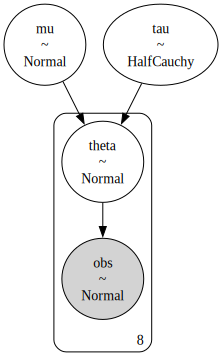

In [4]:
pm.model_to_graphviz(Centered_eight)

In [5]:
# This posterior distribution implied by this specification can be sampled from
# using HMC where the necessary auxiliary variables are added "under the hood"
SEED = [20100420, 20134234] # random seeds for each of two run HMC chains
with Centered_eight:
    fit_C = pm.sample(5000, chains=2, tune=1000, random_seed=SEED,
                      return_inferencedata=True, idata_kwargs={"log_likelihood": True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [mu, tau, theta]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 5 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [6]:
# We can get some more information by turning on logging
import logging # dir(logging) for available functionality
_log = logging.getLogger("pymc")
#_log.setLevel(logging.NOTSET) # 0
_log.setLevel(logging.INFO) # 20
#_log.setLevel(logging.WARNING) # 30
#_log.setLevel(logging.ERROR) # 40

In [7]:
# We now see that the NUTS implementation (version of HMC) is being used to
# sample from the posterior distributions of our parameters [mu, tau, theta]
SEED = [20100420, 20134234]
with Centered_eight:
    fit_C = pm.sample(5000, chains=2, tune=1000, random_seed=SEED,
                      return_inferencedata=True, idata_kwargs={"log_likelihood": True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [mu, tau, theta]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 5 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Divergences here mean that $\tau$ was sampled with a small value so that previous $\theta_i$ no longer appear to be reasonable values under $\mathcal{N}(\mu, \tau)$. Their density evaluation is now extremely small (probably even numerically $0$). We have therefore "flown off" the mass of our target distribution. But we can fix this with a different parameterization.

In [8]:
# As is seen above, there are many divergences because the specification above
# induces high curature in the energy, but the following alternative
# parameterization alleviates this problem.

with pm.Model() as NonCentered_eight:

    mu = pm.Normal("mu", mu=0, sigma=5)
    tau = pm.HalfCauchy("tau", beta=5)
    theta_tilde = pm.Normal("theta_t", mu=0, sigma=1, shape=J)
    # Changes in theta now take place on a fixed scale that is independent of tau

    theta = pm.Deterministic("theta", mu + tau * theta_tilde)
    # Changes in tau can still result in rapid changes in the density evaluations
    # below so the energy still has high curvature with respect to tau; but,
    # it no longer has high curvature with respect to theta
    obs = pm.Normal("obs", mu=theta, sigma=sigma, observed=y)

In [9]:
with NonCentered_eight:
    fit_NC = pm.sample(5000, chains=2, tune=1000, random_seed=SEED,
                       return_inferencedata=True, idata_kwargs={"log_likelihood": True})
# Now very few divergences... problem solved!

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [mu, tau, theta_t]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


The `theta = pm.Deterministic("theta", mu + tau * theta_tilde)` line above also shows that probabilistic programming can introduce formulas into our hierarchical specifications... so you might now be able to imagine embedding a linear model into some of our distributional specifications...

There are two things that matter for HMC performance:
1. Metropolis-Hastings Acceptance Rates
2. Autocorrelation in the Markov Chain
  - How far was the proposal able to move away from the current state?
  - The further away, the more independent, and the greater the effective sample size

Below we examine some of the HMC performance diagnostics available from
- https://www.pymc.io/projects/examples/en/latest/diagnostics_and_criticism/sampler-stats.html


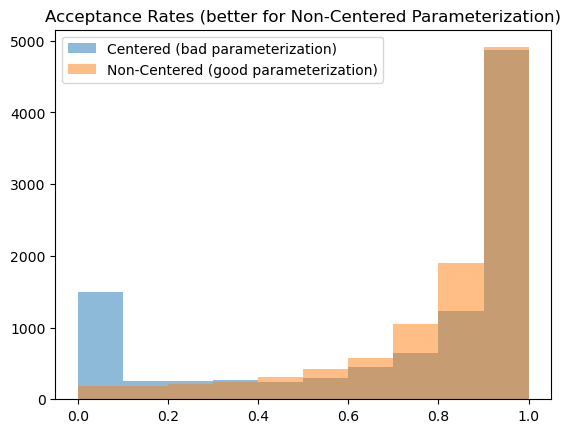

In [10]:
import matplotlib.pyplot as plt
plt.hist(fit_C.sample_stats.acceptance_rate.values.flatten(), alpha=0.5,
         label='Centered (bad parameterization)');
plt.hist(fit_NC.sample_stats.acceptance_rate.values.flatten(), alpha=0.5,
         label='Non-Centered (good parameterization)');
plt.title('Acceptance Rates (better for Non-Centered Parameterization)'); plt.legend();

In [11]:
import pandas as pd
print("Effective Sample Sizes (function of Markov Chain autocorrelation dependency)")
pd.concat(
[pd.DataFrame({'Centered': pm.summary(fit_C)[:1]['ess_bulk'],
              'Non-Centered': pm.summary(fit_NC)['ess_bulk'][:1]}),
 pd.DataFrame({'Centered': pm.summary(fit_C)[1:]['ess_bulk'],
              'Non-Centered': pm.summary(fit_NC)['ess_bulk'][9:]})])

Effective Sample Sizes (function of Markov Chain autocorrelation dependency)


,Centered,Non-Centered
mu,1370.0,11693.0
tau,193.0,5444.0
theta[0],1064.0,11217.0
theta[1],2186.0,11753.0
theta[2],2147.0,10258.0
theta[3],2084.0,12413.0
theta[4],1599.0,10156.0
theta[5],2291.0,11272.0
theta[6],977.0,10519.0
theta[7],2128.0,10670.0


Our demonstration in this notebook will stop here, but if you're interested in seeing more about what a full Bayesian posterior inference analysis looks like, have a look at the [getting started with `PyMC`](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/pymc_overview.html) materials [here](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/pymc_overview.html#posterior-analysis)

You could also follow up on some further examination of the specification of the "Eight Schools Model" [here](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/model_comparison.html) and can also return to the more detailed analysis [here](https://www.pymc.io/projects/examples/en/latest/diagnostics_and_criticism/Diagnosing_biased_Inference_with_Divergences.html#the-eight-schools-model).

If you have a look at the "Introductory Overview of PyMC" notebook, you'll see "Section Navigation" with a link to [GLM: Linear regression](https://www.pymc.io/projects/docs/en/latest/learn/core_notebooks/GLM_linear.html). This might be a good place to look at first when you're starting your homework.  You will also likely find the [`PyMC` Example Gallery](https://www.pymc.io/projects/examples/en/latest/gallery.html) useful... especially the section titled [generalized linear models](https://www.pymc.io/projects/examples/en/latest/gallery.html#generalized-linear-models)...
